In [60]:
# import stuff

import numpy as np
import math as m
import pandas as pd
import matplotlib.pyplot as plt
import os
os.chdir('C:\\Users\\nicol\\Desktop\\pythonfiles\\micrometereology\\04')

from windrose import WindroseAxes
from scipy.optimize import minimize
from scipy.special import gamma
from scipy.integrate import quad
import matplotlib.patches as patches
from matplotlib.patches import Rectangle


In [35]:
def compute_Weibull_parameters(array):
    mean = np.mean(array)
    variance = np.var(array)

    # Define a function to calculate the moments of the Weibull distribution
    def weibull_moments(params):
        k, lambd = params
        mu = lambd * gamma(1 + 1/k)
        m2 = (lambd**2 * gamma(1 + 2/k)) - mu**2
        return np.array([mu, m2])

    #Define a function to calculate the difference between observed and estimated moments
    def moment_error(params):
        observed_moments = np.array([mean, variance])
        estimated_moments = weibull_moments(params)
        return np.sum((observed_moments - estimated_moments)**2)

    # Initial guesses for k and lambd
    initial_guess = [1.0, 1.0]

    # Minimize the error function to estimate parameters
    result = minimize(moment_error, initial_guess, method='Nelder-Mead')

    # Extract estimated parameters
    estimated_k, estimated_lambda = result.x

    return(estimated_k,estimated_lambda)


def compute_Weibull(array):
    k, lam = compute_Weibull_parameters(array)

    x = np.linspace(0.01, max(array), num=len(array))
    #x = np.sort(array)
    y = k/x * (x / lam)**k * np.exp(-(x/lam)**k)

    array_name = [name for name, value in globals().items() if value is array][0]
    plt.plot(x, y)
    print(f'for {array_name}: k = {k:.2f} and lam = {lam:.2f}')


def plot_histogram(array_data, num, color, label):
    # plots the histogram of an array of data
    x = np.linspace(min(array_data), max(array_data), num=num)
    y = np.histogram(array_data, bins=num, density=True)
    delta = num/10000
    width_bar = (max(array_data) - min(array_data)) / num + delta
    #width_bar = (max(array_data) - min(array_data)) / num
    plt.bar(x, y[0], width=width_bar, align='center', color=color, label=label)
    area = np.sum(y[0]*(width_bar))
    area = np.sum(y[0]*(width_bar-delta))
    print(f"area under graph = {area:.5f}")

def plot_Weibull(array_data, k, lam, color, label):
    # computes the Weibull distribution given k and lamda and plots it in the range of the data to avoid zeros
    x = np.linspace(0.001, max(array_data), num=100)
    y = k/x * (x / lam)**k * np.exp(-(x/lam)**k)
    plt.plot(x, y, color=color, label=label)



def divide_in_sector(velocity, direction, time):
    
    indices = np.argsort(direction)[::-1]

    V_sorted = velocity[indices]
    dir_sorted = direction[indices]
    time_sorted = time[indices]

    data_sector = [[],[],[],[],[],[],[],[],[],[],[],[]]
    for j in range(1, len(data_sector)):
        for i in range(len(dir_sorted)):
            low = (j - 1) * 30 + 15
            high = (j) * 30 + 15
            if low <= dir_sorted[i] < high:
                data_sector[j].append(V_sorted[i])
    for i in range(len(dir_sorted)):
        if dir_sorted[i] < 15 or dir_sorted[i] >= 345:
            data_sector[0].append(V_sorted[i])

    return data_sector


def Weibull(U, k, A):
    y = k/U * (U/A)**k * np.exp(-(U/A)**k)
    return y

def compute_u_star_waterland_array(G_array, fc, z0land, z0water, A, B, eps, max_iteration):
    u_star_array = []
    for G in G_array:
        u_star, u_star_new = 1, 1
        kk, count = 0,0

        while kk==0:
            count += 1
            u_star = u_star_new
            u_star_new =  G*k /np.sqrt((np.log((u_star/fc)/z0land) - A)**2 + B**2)

            if abs(u_star_new - u_star) < eps:
                kk=1
            if count > max_iteration:
                kk=1
                #print('not convergent')
        u_star_array.append(u_star_new)
    return np.array(u_star_array)

def transfer_wind(land_direction, data, k, fc, A, B, z0water, z0land):
    data_new = []
    for i in range(len(data)):
        if i in land_direction:
            u_star = np.array(data[i])*k*1/np.log(70/z0water)
            G = u_star/k * np.sqrt((np.log((u_star/fc)/z0water) - A)**2 + B**2)
            u_star_new = compute_u_star_waterland_array(G_array=G, fc=fc, z0land=z0land, z0water=z0water, A=A, B=B, eps=eps, max_iteration=max_iteration)
            U120 = u_star_new/k*np.log(120/z0land)
        else:
            U120 = np.array(data[i])
        data_new.append(U120)
    return data_new

def transfer_wind_up(data, k, fc, A, B, z0water, z0land):
    data_new = []
    for i in range(len(data)):
        u_star = np.array(data[i])*k*1/np.log(70/z0water)
        U120 = u_star/k*np.log(120/z0water)
        data_new.append(U120)
    return data_new

def compute_AEP(data_sector, Prated, Urp, Ucutoff, T, Umax, num):
    
    E = []
    U_array = np.linspace(0.01,Umax, num=num1)
    total = sum(len(sublist) for sublist in data_sector)

    for i in range(len(data_sector)):
        sector = data_sector[i]
        fi = len(sector)/total

        k, A = compute_Weibull_parameters(sector)
        #print(f'for sector {i}: f = {fi:.4f}, k = {k:.2f} and A = {A:.2f}')

        integral = 0

        for U in U_array:
            y1 = Weibull(U, k, A)
            if U <= Urp:
                y2 = Prated*(U/Urp)**3
            elif Urp < U <=Ucutoff:
                y2 = Prated
            else:
                y2 = 0
            rect = y1*y2*Umax/num1
            integral = integral + rect
        
        E.append(T*fi*integral)
    AEP = np.sum(E)
    return AEP, E

def divide_in_year_january(V_array, time_array, dir_array):
    tot_velocities = len(V_array)

    velocity_by_year = {}
    direction_by_year = {}

    for i in range(len(V_array)):
        year = int(time_array[i] // 100000000)

        if year not in velocity_by_year:
            velocity_by_year[year] = []
            direction_by_year[year] = []
        velocity_by_year[year].append(V_array[i])
        direction_by_year[year].append(dir_array[i])
    return velocity_by_year, direction_by_year

def divide_in_year_september(V_array, time_array, dir_array):

    velocity_by_year = {}
    direction_by_year = {}
    time_by_year = {}

    for i in range(len(V_array)):
        year = int(time_array[i] // 100000000)
        month = int(str(time_array[i])[4:6])

        if year not in velocity_by_year:
            velocity_by_year[year] = []
            direction_by_year[year] = []
            time_by_year[year] = []

        if month >= 9:
            velocity_by_year[year].append(V_array[i])
            direction_by_year[year].append(dir_array[i])
            time_by_year[year].append(time_array[i])
        else:
            velocity_by_year[year-1].append(V_array[i])
            direction_by_year[year-1].append(dir_array[i])
            time_by_year[year-1].append(time_array[i])
    return velocity_by_year, direction_by_year, time_by_year




In [46]:
# DATA

data = pd.read_csv('sprog.tsv', delimiter='\t', header=None, 
                    names=['t','V','dir67', 'dir70'])

time_all = data['t'].values
V_all = data['V'].values
dir67_all = data['dir67'].values
dir70_all = data['dir70'].values

V_array = []
dir_array = []
time_array = []
for i in range(len(V_all)):
    if V_all[i] < 90:
        if dir67_all[i] < 900:
            V_array.append(V_all[i])
            dir_array.append(dir67_all[i])
            time_array.append(time_all[i])
        elif dir70_all[i] < 900:
            V_array.append(V_all[i])
            dir_array.append(dir70_all[i])
            time_array.append(time_all[i])

V_array = np.array(V_array)
dir_array = np.array(dir_array)
time_array = np.array(time_array)

num=100
Prated = 13*10**6
Urp = 12
Ucutoff = 25
Umax = 30
num1 = 10000
T = 24*365

land_west = [7,8,9,10]
land_east = [1,2,3,4]

k = 0.4
z0water = 2*10**-4
z0land = 2.5*10**-2
z120 = 120
z70 = 70

phi = 55.33
omegaE = 7.2921*10**-5
fc = 2*omegaE*np.sin(np.deg2rad(phi))
A = 1.8
B = 4.5

eps = 1e-3
max_iteration = 1000




for V_array: k = 2.23 and lam = 9.29
area under graph = 1.00000


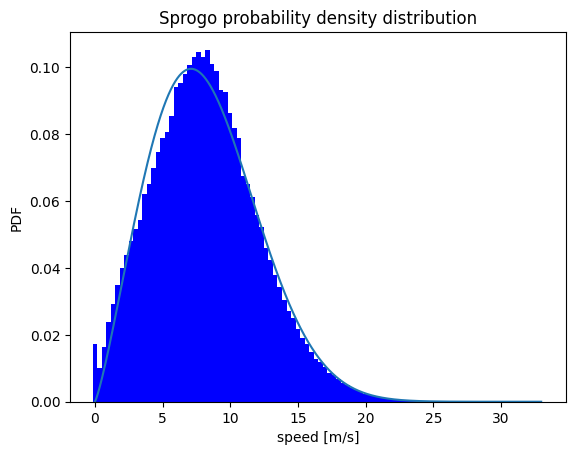

In [39]:
compute_Weibull(V_array)
plot_histogram(array_data=V_array, num=num, color='b', label='Histrogram')
plt.title("Sprogo probability density distribution")
plt.xlabel("speed [m/s]")
plt.ylabel("PDF")
plt.show()

Text(0.5, 1.0, 'All data')

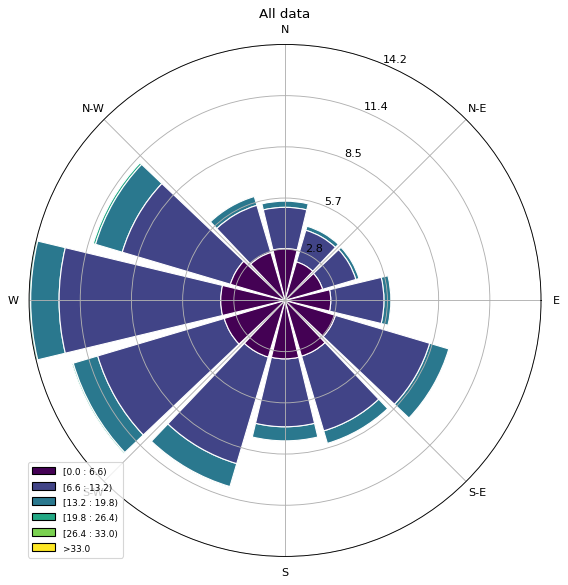

In [40]:
# WIND ROSE

ax = WindroseAxes.from_ax()
ax.bar(dir_array, V_array, normed=True, opening=0.9, edgecolor='white', nsector=12)
ax.set_legend()
ax.set_title('All data')

maximum AEP  = 113.88 [GWh]
computed AEP =  46.55 [GWh]


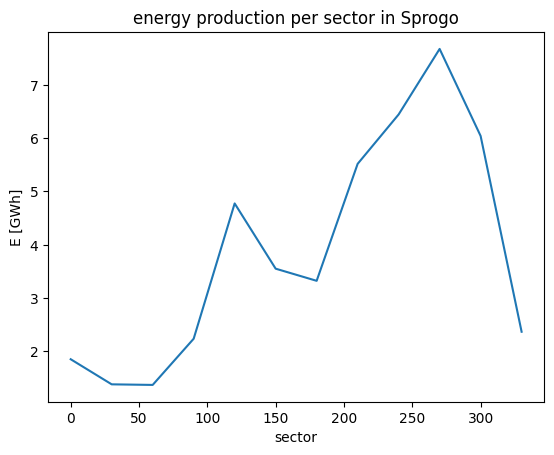

In [41]:
# COMPUTE AEP at 70 m in Sprogo

data_sector = divide_in_sector(velocity=V_array, direction=dir_array, time=time_array)

AEP_tot, E_tot =  compute_AEP(data_sector=data_sector, Prated=Prated, Urp=Urp, Ucutoff=Ucutoff, Umax=Umax, T=T, num=num1)
print(f'maximum AEP  = {T*Prated/10**9:6.2f} [GWh]')
print(f'computed AEP = {AEP_tot/10**9:6.2f} [GWh]')

direction = np.arange(0, 360, 30)
plt.plot(direction, np.array(E_tot)/10**9)
plt.title('energy production per sector in Sprogo')
plt.ylabel('E [GWh]')
plt.xlabel('sector')

plt.show()

sorted by frequency
freq [ 1052 29811 41233 41441 48389 49992 50718 51609 51998 52176 52202 52385
 52455 52517 52528 52530 52530 52541 52544 52547 52554 52662 52690]
year [1999 1988 1987 1979 1981 1980 1977 1982 1994 1978 1992 1993 1996 1995
 1984 1985 1986 1989 1998 1990 1997 1983 1991]
mean [5.72352662 8.23418839 8.67016516 8.20384909 7.5304253  8.89696972
 8.15757818 8.34318549 8.83277203 8.60664616 8.32238497 8.27365792
 7.85649948 7.5693663  8.01146646 8.10253436 8.23394365 8.1357005
 8.01920276 7.81183893 8.44969536 8.51661046 8.28568969]

average of measurements per year: 47874
data excluded:       5.72, 8.23 [m/s]
for the year :       1999, 1988
having measurements: 1052, 29811
average elements per year without outliars= 50963

max average speed of 8.90 [m/s] for year 1980
min average speed of 7.53 [m/s] for year 1981


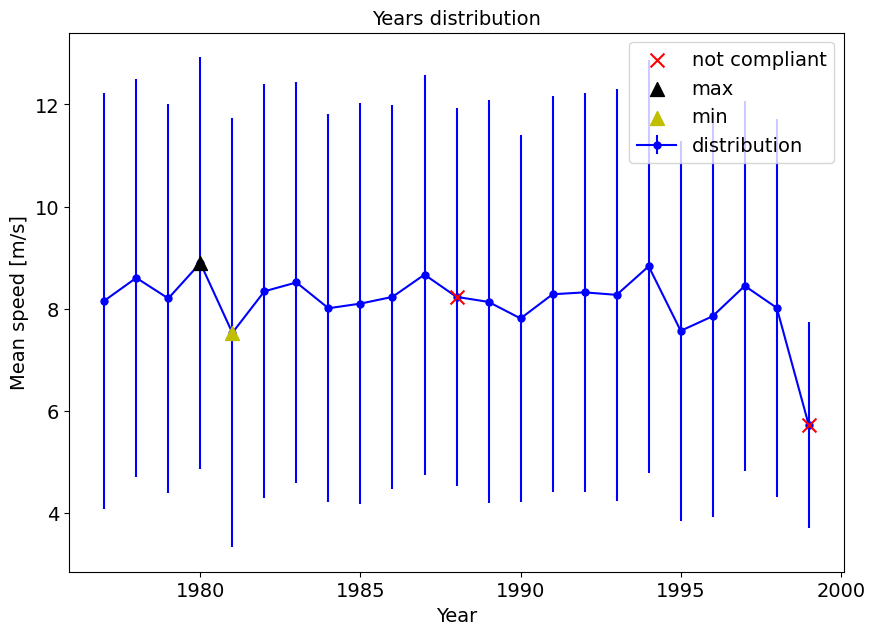

In [42]:
# find most and least windy year
# data in Sprogo 70 m

velocity_by_year, direction_by_year,time_by_year  = divide_in_year_september(V_array, time_array, dir_array)

year_array = []
mean_array = []
std_array = []
freq_array = []

for year, velocities in velocity_by_year.items():
    mean_velocity = np.mean(velocities)
    std_velocity = np.std(velocities)
    freq_velocity = len(velocities)
    year_array.append(year)
    mean_array.append(mean_velocity)
    std_array.append(std_velocity)
    freq_array.append(freq_velocity)

year_array = np.array(year_array)
mean_array = np.array(mean_array)
std_array = np.array(std_array)
freq_array = np.array(freq_array)

indices_byfreq = np.argsort(freq_array)[::]
year_sort = year_array[indices_byfreq]
mean_sort = mean_array[indices_byfreq]
freq_sort = freq_array[indices_byfreq]

print('sorted by frequency')
print('freq',freq_sort)
print('year', year_sort)
print('mean',mean_sort)


print('')
print(f'average of measurements per year: {int(np.mean(freq_sort)):.0f}')
print(f'data excluded:       {mean_sort[0]:.2f}, {mean_sort[1]:.2f} [m/s]')
print(f'for the year :       {year_sort[0]:.0f}, {year_sort[1]:.0f}')
print(f'having measurements: {freq_sort[0]:.0f}, {freq_sort[1]:.0f}')

# remove the year with too few data
year_sort1 = year_sort[2:]
mean_sort1 = mean_sort[2:]
freq_sort1 = freq_sort[2:]
print(f'average elements per year without outliars= {int(np.mean(freq_sort1)):.0f}')

max_index = np.argmax(mean_sort1)
min_index = np.argmin(mean_sort1)
max_value = mean_sort1[max_index]
min_value = mean_sort1[min_index]
max_year = year_sort1[max_index]
min_year = year_sort1[min_index]

print('')
print(f'max average speed of {max_value:.2f} [m/s] for year {max_year}')
print(f'min average speed of {min_value:.2f} [m/s] for year {min_year}')

plt.figure(1, figsize=(10,7))
plt.rc('font', size=14)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=14)

plt.errorbar(x=year_array, y=mean_array, yerr=std_array, marker='o', markersize=5, color='b', zorder=1, label='distribution')
plt.scatter(x=year_sort[0:2], y=mean_sort[0:2],         marker='x', s=100, color='r', zorder=2, label='not compliant')
plt.scatter(x=max_year, y=max_value,                    marker='^', s=100, color='k',zorder=2, label='max')
plt.scatter(x=min_year, y=min_value,                    marker='^', s=100, color='y',zorder=2, label='min')

plt.legend()
plt.title('Years distribution')
plt.ylabel('Mean speed [m/s]')
plt.xlabel('Year')
plt.show()




computed AEP most windy =  52.90 [GWh]
computed AEP least windy =  40.15 [GWh]


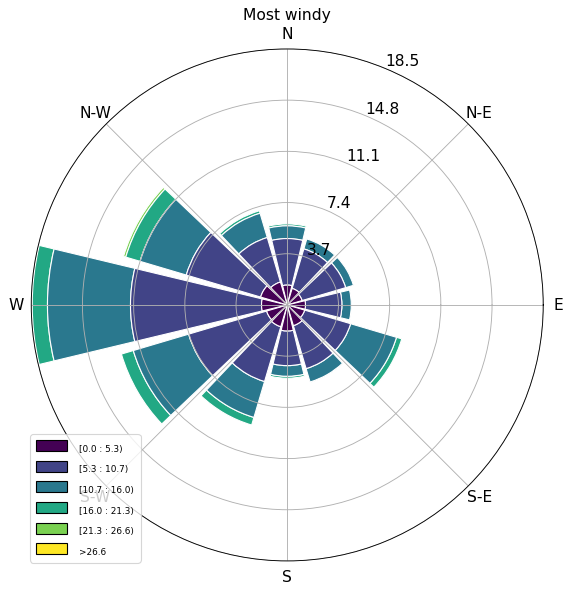

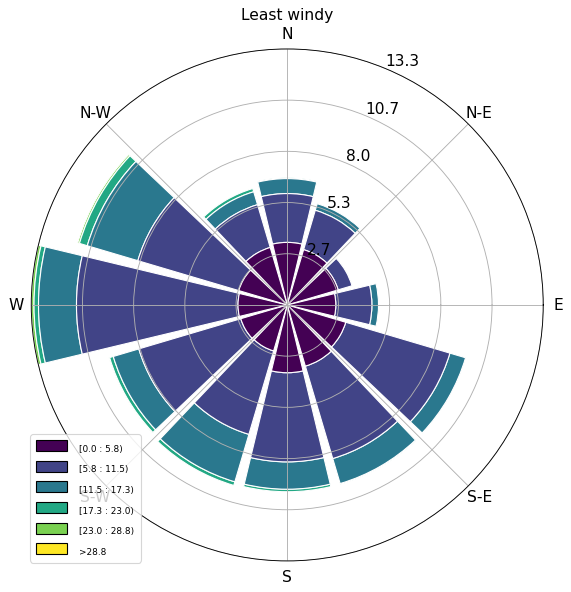

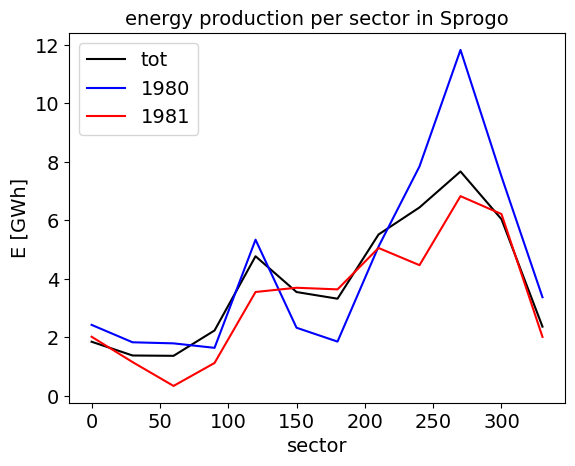

In [44]:
# do again for west and east



# most windy excluding outliers
# year 1980

max_V_array = np.array(velocity_by_year[1980])
max_dir_array = np.array(direction_by_year[1980])
max_time_array = np.array(time_by_year[1980])

max_data_sector = divide_in_sector(velocity=max_V_array, direction=max_dir_array, time=max_time_array)
AEP_max, E_max =  compute_AEP(data_sector=max_data_sector, Prated=Prated, Urp=Urp, Ucutoff=Ucutoff, T =T, Umax=Umax, num=num1)

print(f'computed AEP most windy = {AEP_max/10**9:6.2f} [GWh]')


# least windy excluding outliers
# year 1981

min_V_array = np.array(velocity_by_year[1981])
min_dir_array = np.array(direction_by_year[1981])
min_time_array = np.array(time_by_year[1981])

min_data_sector = divide_in_sector(velocity=min_V_array, direction=min_dir_array, time=min_time_array)
AEP_min, E_min =  compute_AEP(data_sector=min_data_sector, Prated=Prated, Urp=Urp, Ucutoff=Ucutoff, Umax=Umax, T=T, num=num1)

print(f'computed AEP least windy = {AEP_min/10**9:6.2f} [GWh]')

ax = WindroseAxes.from_ax()
ax.bar(max_dir_array, max_V_array, normed=True, opening=0.9, edgecolor='white', nsector=12)
ax.set_legend()
ax.set_title('Most windy')

ax = WindroseAxes.from_ax()
ax.bar(min_dir_array, min_V_array, normed=True, opening=0.9, edgecolor='white', nsector=12)
ax.set_legend()
ax.set_title('Least windy')


plt.figure(3)
plt.plot(direction, np.array(E_tot)/10**9, color='k', label='tot')
plt.plot(direction, np.array(E_max)/10**9, color='b', label='1980')
plt.plot(direction, np.array(E_min)/10**9, color='r', label='1981')
plt.title('energy production per sector in Sprogo')
plt.ylabel('E [GWh]')
plt.xlabel('sector')
plt.legend()

plt.show()


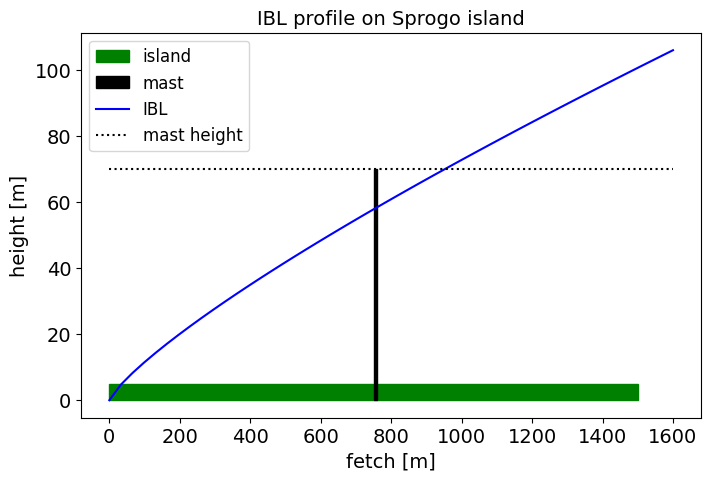

In [81]:
# effect of sprogo being tecnically on land

k = 0.4
z0water = 2*10**-4
z0land = 2.5*10**-2
z120 = 120
z70 = 70

Lisland = 1500


# from elliott parametrization
x1 = np.linspace(0,1600)
hub = np.full(len(x1), z70)

IBLwaterland =  z0land*(0.75 + 0.03*np.log(z0water/z0land))*(x1/z0land)**0.8
IBL_island = z0land*(0.75 + 0.03*np.log(z0water/z0land))*(Lisland/z0land)**0.8


fig, ax = plt.subplots(1, figsize=(8,5))
rectangle = patches.Rectangle((0.0, 0.0), 1500, 5, linewidth=1, edgecolor='g', facecolor='g', label='island')
ax.add_patch(rectangle)
rectangle = patches.Rectangle((750, 0.0), 10, 70, linewidth=1, edgecolor='k', facecolor='k', label='mast')
ax.add_patch(rectangle)
ax.plot(x1, IBLwaterland, color = "b", label='IBL')
ax.plot(x1, hub, color='k', linestyle='dotted', label='mast height')

ax.set_xlabel('fetch [m]')
ax.set_ylabel('height [m]')
ax.set_title('IBL profile on Sprogo island')

ax.legend()
ax.legend(fontsize='12')
plt.show()




In [47]:
# trasnfer data

#data_sector = divide_in_sector(velocity=V_array, direction=dir_array, time=time_array)




print(f'maximum AEP  = {T*Prated/10**9:6.2f} [GWh]')

data_center =  transfer_wind_up(data=data_sector, k=k, fc=fc, A=A, B=B, z0water=z0water, z0land=z0land)
AEP_center, E_center =  compute_AEP(data_sector=data_center, Prated=Prated, Urp=Urp, Ucutoff=Ucutoff, Umax=Umax, T=T, num=num1)

data_west =  transfer_wind(land_direction=land_west, data=data_sector, k=k, fc=fc, A=A, B=B, z0water=z0water, z0land=z0land)
AEP_west, E_west =  compute_AEP(data_sector=data_west, Prated=Prated, Urp=Urp, Ucutoff=Ucutoff, Umax=Umax, T=T, num=num1)

data_east =  transfer_wind(land_direction=land_east, data=data_sector, k=k, fc=fc, A=A, B=B, z0water=z0water, z0land=z0land)
AEP_east, E_east =  compute_AEP(data_sector=data_east, Prated=Prated, Urp=Urp, Ucutoff=Ucutoff, Umax=Umax, T=T, num=num1)

print(f'center AEP = {AEP_center/10**9:6.2f} [GWh]')
print(f'west AEP = {AEP_west/10**9:6.2f} [GWh]')
print(f'east AEP = {AEP_east/10**9:6.2f} [GWh]')


maximum AEP  = 113.88 [GWh]


C:\Users\nicol\AppData\Local\Temp\ipykernel_16164\3933589459.py:112: RuntimeWarning: divide by zero encountered in log
  G = u_star/k * np.sqrt((np.log((u_star/fc)/z0water) - A)**2 + B**2)
C:\Users\nicol\AppData\Local\Temp\ipykernel_16164\3933589459.py:112: RuntimeWarning: invalid value encountered in multiply
  G = u_star/k * np.sqrt((np.log((u_star/fc)/z0water) - A)**2 + B**2)


center AEP =  49.89 [GWh]
west AEP =  21.07 [GWh]
east AEP =  36.87 [GWh]


In [31]:
for i in range(0,11):
    print(f'center {len(data_center[i])}, west {len(data_west[i])}, east {len(data_east[i])}')

center 60728, west 60728, east 60728
center 47292, west 47292, east 47292
center 47175, west 47175, east 47175
center 64639, west 64639, east 64639
center 104453, west 104453, east 104453
center 91123, west 91123, east 91123
center 86006, west 86006, east 86006
center 119114, west 119114, east 119114
center 135729, west 135729, east 135729
center 156280, west 156280, east 156280
center 122117, west 122117, east 122117
